## Embedding Reveiws
- Run on A100

In [ ]:
!pip install transformers

In [8]:
import transformers
import torch

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
!pip install --upgrade huggingface_hub

In [2]:
from huggingface_hub import login

In [3]:
login()

In [8]:
!pip install pandas==2.2.2
!pip install numpy<3.0.0,>=2.0.0

/bin/bash: line 1: 3.0.0,: No such file or directory


In [1]:
!pip install gensim nltk

In [ ]:
!pip install --force-reinstall gensim

In [3]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from gensim.models import Word2Vec
import gensim

# Tutorial from NLTK: https://www.nltk.org/data.html
# train the word2vec model that learns the word meaning in the bubble tea reviews

In [4]:
# nltk.download() # this one runs endless
nltk.download('punkt')
nltk.download('punkt_tab')
# punkt explains: https://www.askpython.com/python-modules/nltk-punkt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Preprocess Data

In [5]:
df = pd.read_csv("All Reviews.csv")

# df['Rating'] = df['Rating'].str.extract(r"(\d+)")
# for i in range(len(df)):
#     if df['Reviews'][i] == 'No review text available':
#         df = df.drop(i)

reviews = df["Reviews"]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   607 non-null    int64 
 1   Reviews  607 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.6+ KB


## Word2Vec
- tutorial: https://radimrehurek.com/gensim/models/word2vec.html

In [60]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha()] # if word is alphabet letters

tokenized_reviews = []
# tokenize each review
for review in reviews:
    tokenized_reviews.append(preprocess(review))

# tokenized_reviews
# [['babo', 'tea'],['I','love', 'this']... ]

In [61]:
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=300, window=5, min_count=2, workers=4)

In [62]:
# This func transfers review tokens into vectors
def get_w2v_review_vector(tokens, model):

    # only keep the word in W2V model's vocabulary
    recognized_word_in_review= []
    word_vector = []

    for w in tokens:
        if w in model.wv.key_to_index: # {'the': 0, 'and': 1, 'i': 2,...}
            recognized_word_in_review.append(w)

    # if a review contains no model vocabuary, set its vector 0
    if len(recognized_word_in_review) == 0:
        return np.zeros(model.vector_size)

    # if has value, get the word vector and calculate the avg
    for w in recognized_word_in_review:
        word_vector.append(model.wv[w])

    review_vector = np.mean(word_vector, axis = 0)
    return review_vector

In [63]:
w2v_review_vectors = []
for tokens in tokenized_reviews:
    vector = get_w2v_review_vector(tokens, w2v_model)
    w2v_review_vectors.append(vector)

In [64]:
w2v_review_vectors = np.array(w2v_review_vectors) #convert it into a np array
print(w2v_review_vectors.shape)
# 607 reviews, each review is represented as 100-D vector

(607, 300)


Normalize rating & Reshape dimentions: convert 1-5 scale into 0~1

In [18]:
ratings = df["Rating"]
normalized_ratings = np.array(ratings, dtype=float) / 5

# reshape normalized ratings into (607, 1)
reshaped_ratings = normalized_ratings.reshape(-1,1)
reshaped_ratings.shape

(607, 1)

Combine normalized ratings with review vectors

In [ ]:
w2v_rating_combined_vectors = np.hstack((w2v_review_vectors, reshaped_ratings))
w2v_rating_combined_vectors.shape

## TF-IDF

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(reviews)
tfidf_vectors = tfidf_matrix.toarray()

tfidf_rating_combined_vectors = np.hstack((tfidf_vectors, reshaped_ratings))
tfidf_rating_combined_vectors.shape

(607, 301)

## Llama 2-7b-chat-hf
- meta download: https://www.llama.com/llama-downloads/
- Huggingface: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
- [Github tutorial](https://github.com/meta-llama/llama-models?fbclid=IwZXh0bgNhZW0CMTAAAR5flYgamnz7bViaAtMQsPvPWGc7jCd69MsAmom7zGFl6Mb9ckvqDYBeACJirg_aem_vjalf1yaPdUasJh9lNKd_g)

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM

llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
llama_model.config.output_hidden_states = True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
llama_model.to(device)

Using device: cuda


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_e

In [15]:
def get_llama_vector(review, tokenizer, model):

    input = tokenizer(review, return_tensors='pt', truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**input)

    hidden_states = outputs.hidden_states[-1]  #get hidden states from the last layer

    vector = hidden_states.mean(dim=1).squeeze().cpu().numpy() #average all tokens

    return vector

In [16]:
llama_vectors = []

for review in reviews:
    vector = get_llama_vector(review, llama_tokenizer, llama_model)
    llama_vectors.append(vector)


In [20]:
llama_rating_combined_vectors = np.hstack((llama_vectors, reshaped_ratings))
llama_rating_combined_vectors.shape

(607, 4097)

## Falcon

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

falcon_tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b", trust_remote_code=True)
falcon_model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-7b", trust_remote_code=True)
falcon_model.config.output_hidden_states = True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
falcon_model.to(device)

Using device: cuda


FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(65024, 4544)
    (h): ModuleList(
      (0-31): 32 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (maybe_rotary): FalconRotaryEmbedding()
          (query_key_value): FalconLinear(in_features=4544, out_features=4672, bias=False)
          (dense): FalconLinear(in_features=4544, out_features=4544, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): FalconLinear(in_features=4544, out_features=18176, bias=False)
          (act): GELU(approximate='none')
          (dense_4h_to_h): FalconLinear(in_features=18176, out_features=4544, bias=False)
        )
        (input_layernorm): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4544, out_features=65024, bias=False)
)

Generate vectors by using Transformers

In [11]:
def get_falcon_vector(review, tokenizer, model):


    input = tokenizer(review, return_tensors='pt', truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**input)

    hidden_states = outputs.hidden_states[-1]  #get hidden states from the last layer

    vector = hidden_states.mean(dim=1).squeeze().cpu().numpy()  #average all tokens

    return vector

In [12]:
all_falcon_vectors = []

for review in reviews:
    vector = get_falcon_vector(review, falcon_tokenizer, falcon_model)
    all_falcon_vectors.append(vector)


In [15]:
falcon_rating_combined_vectors = np.hstack((all_falcon_vectors, reshaped_ratings))
falcon_rating_combined_vectors.shape

(607, 4545)

## BERT (all-mpnet-base-v2)

In [26]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

bert_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
bert_model = AutoModelForMaskedLM.from_pretrained("sentence-transformers/all-mpnet-base-v2")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  74%|#######4  | 325M/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at sentence-transformers/all-mpnet-base-v2 were not used when initializing MPNetForMaskedLM: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
- This IS expected if you are initializing MPNetForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForMaskedLM were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream

In [32]:
bert_model.config.output_hidden_states = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
bert_model.to(device)

In [34]:
def get_bert_vector(review, tokenizer, model):


    input = tokenizer(review, return_tensors='pt', truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**input)

    hidden_states = outputs.hidden_states[-1]  #get hidden states from the last layer

    vector = hidden_states.mean(dim=1).squeeze().cpu().numpy()  #average all tokens

    return vector

In [35]:
all_bert_vectors = []

for review in reviews:
    vector = get_bert_vector(review, bert_tokenizer, bert_model)
    all_bert_vectors.append(vector)

In [36]:
bert_rating_combined_vectors = np.hstack((all_bert_vectors, reshaped_ratings))
bert_rating_combined_vectors.shape

(607, 769)

In [ ]:
# create a new column df['cluster'], and save as a new csv file



## Kmeans and evaluation (PCA, sil-score)

In [25]:
# function that calculates Silhouette score and shows PCA plot
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_pca_score(model_name, vector):

  for k in range(2,6):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(vector)
    labels = kmeans.labels_

    # if only use sil_score, the value is extremly small, so I use cosine similarity for sil score
    cosine_dist = pairwise_distances(vector, metric='cosine')
    score = silhouette_score(cosine_dist, labels, metric='precomputed')
    # print(f"Silhouette Score for k={k}: {score:.3f}")

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vector)
    centers_reduced = pca.transform(kmeans.cluster_centers_)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='rainbow')
    plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1],
                marker='X', s=100, c='black')
    plt.title(f"{model_name} + K-Means Clustering (K={k}, Sil_score={score:.3f})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(scatter, label='Cluster')

    plt.show()


In [26]:
def score_barchart(model_name, vector):

  k_list = [2,3,4,5] #x
  sil_score_list = [] #y

  for k in k_list:
      kmeans = KMeans(n_clusters = k, random_state=42)
      kmeans.fit(vector)
      labels = kmeans.labels_
      cosine_dist = pairwise_distances(vector, metric='cosine')
      score = silhouette_score(cosine_dist, labels, metric='precomputed')
      sil_score_list.append(score)

  plt.bar(k_list, sil_score_list,width=0.6)
  plt.xlabel("K")
  plt.xticks(k_list, [str(k) for k in k_list])
  plt.ylabel("Silhouette Score")
  plt.title(f"{model_name} + K-Means Clustering")
  plt.show()


### w2v PCA

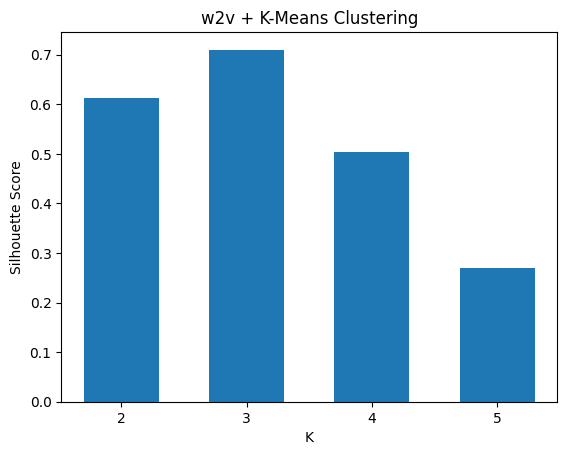

In [91]:
score_barchart("w2v", w2v_rating_combined_vectors)

In [92]:
# save the best k value
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(w2v_rating_combined_vectors)
df['w2v_cluster'] = clusters

df.to_csv('All Reviews_cluster.csv', index=False)

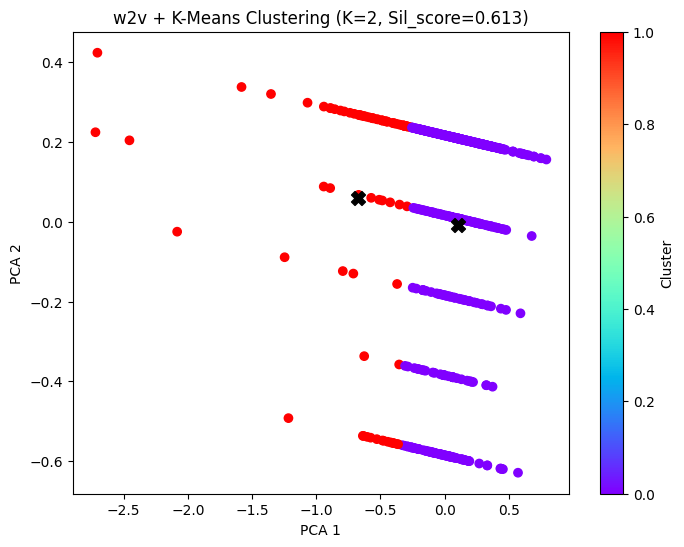

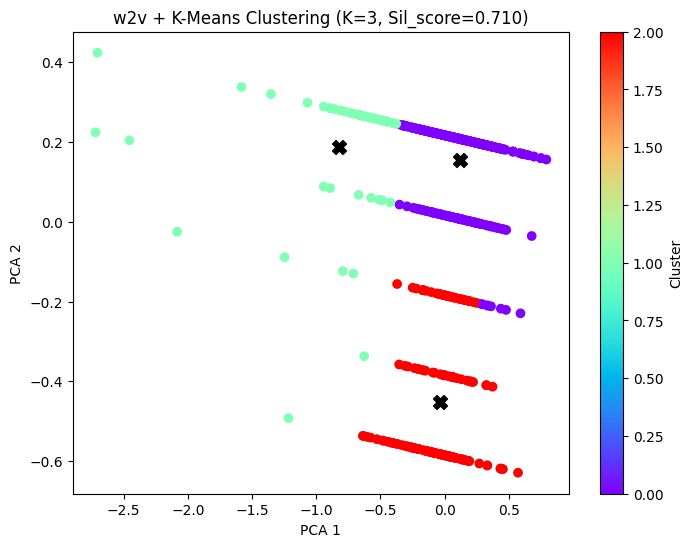

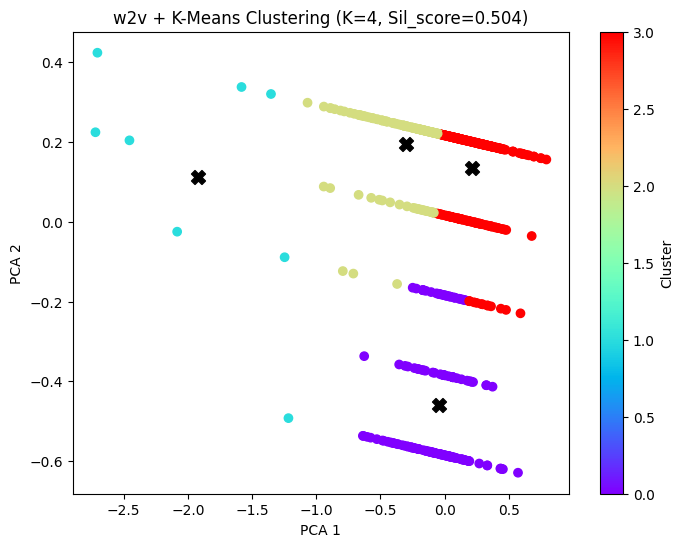

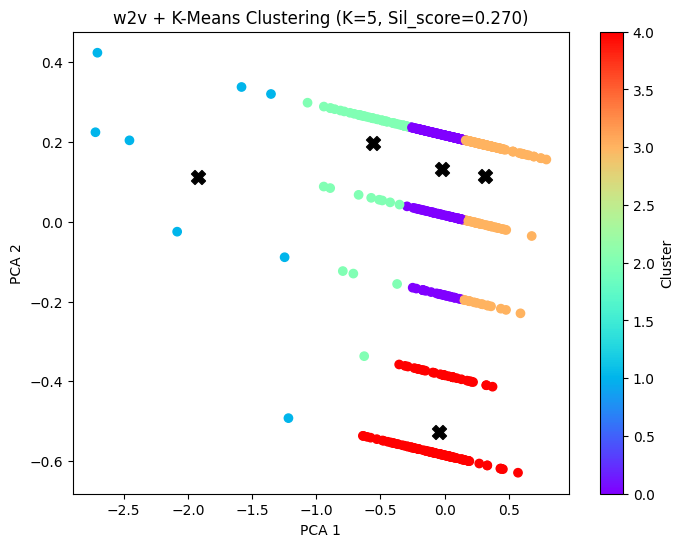

In [80]:
get_pca_score("w2v", w2v_rating_combined_vectors)

### TF-IDF PCA

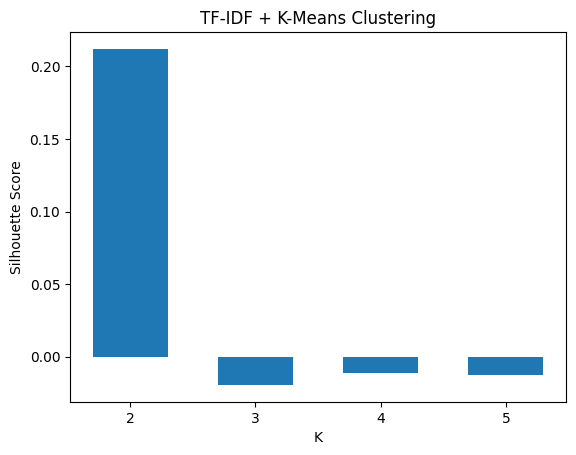

In [93]:
score_barchart("TF-IDF", tfidf_rating_combined_vectors)

Silhouette Score for k=2: 0.212


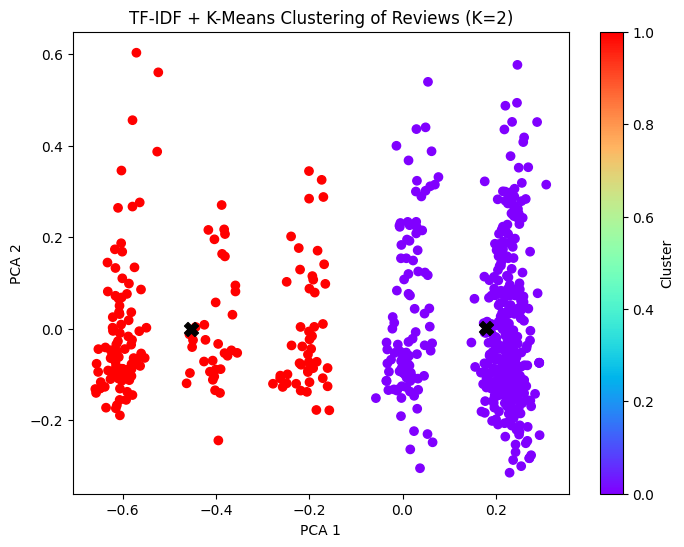

Silhouette Score for k=3: -0.019


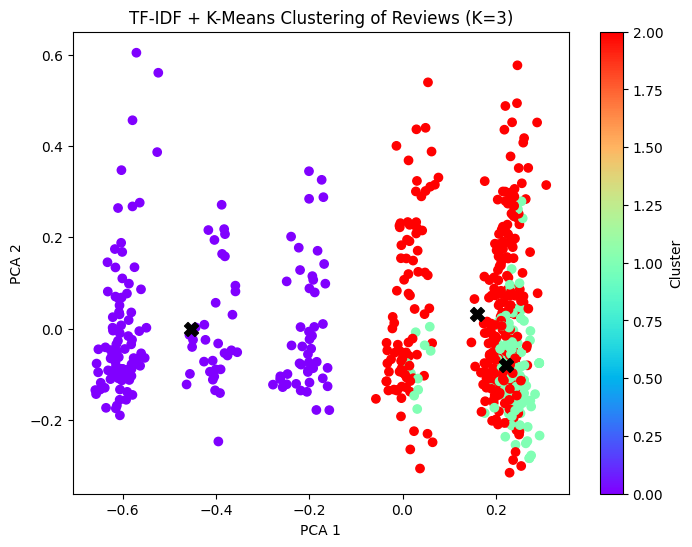

Silhouette Score for k=4: -0.011


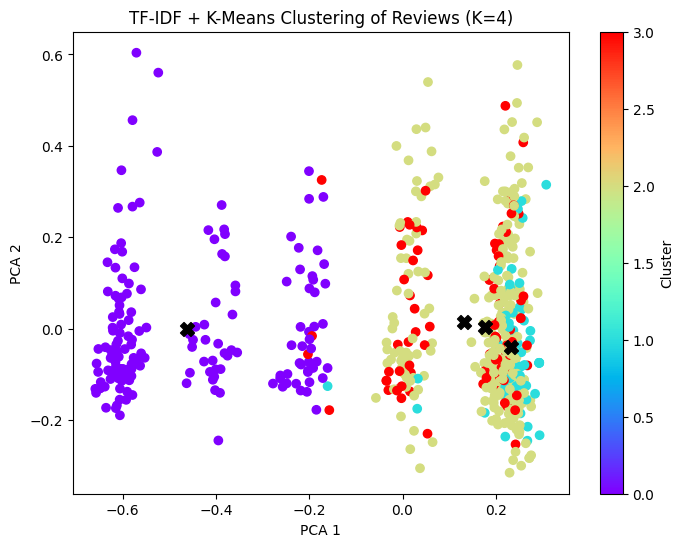

Silhouette Score for k=5: -0.013


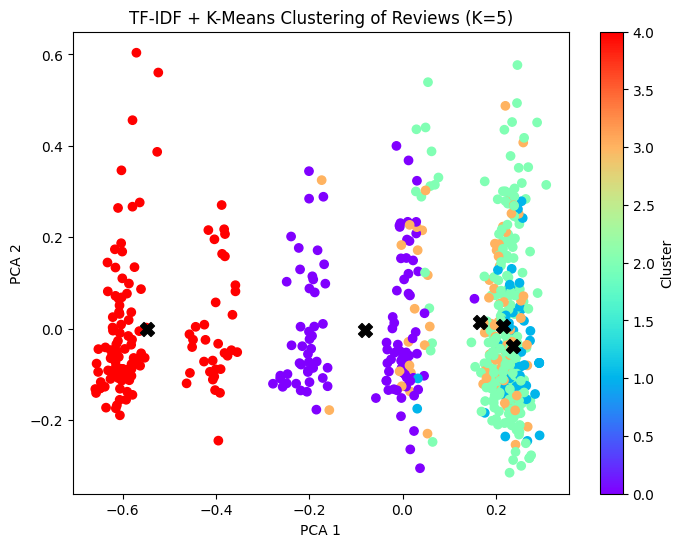

In [73]:
get_pca_score("TF-IDF", tfidf_rating_combined_vectors)

### BERT PCA

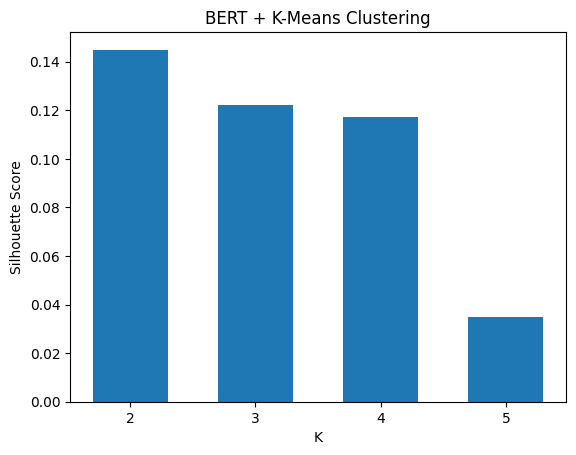

In [94]:
score_barchart("BERT", bert_rating_combined_vectors)

Silhouette Score for k=2: 0.145


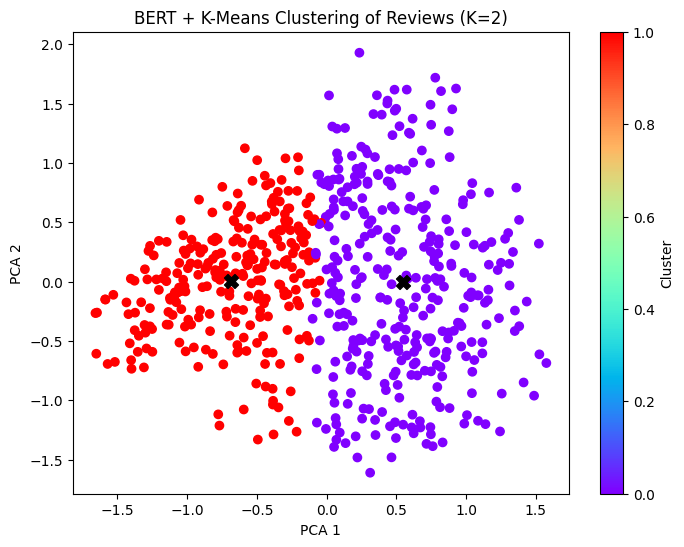

Silhouette Score for k=3: 0.122


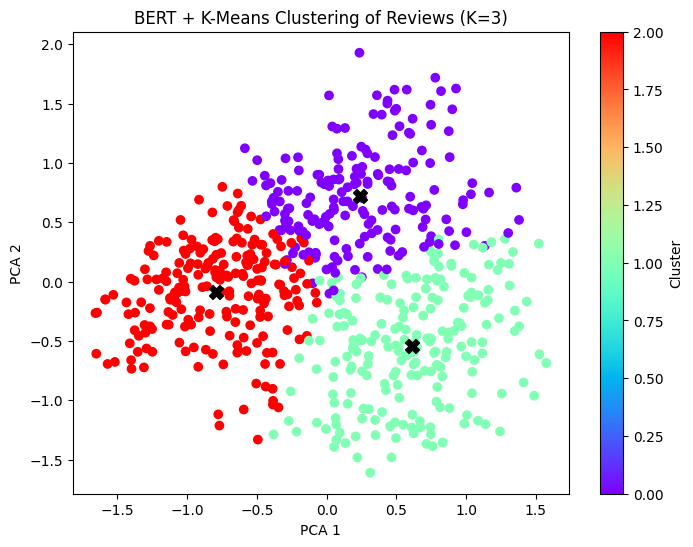

Silhouette Score for k=4: 0.117


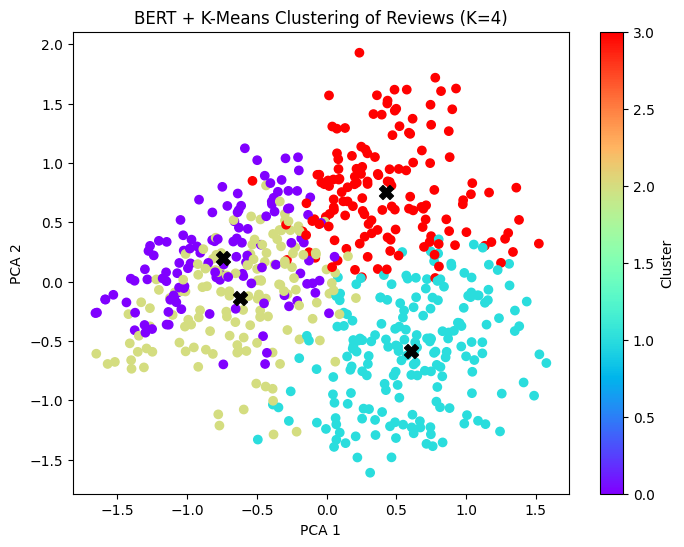

Silhouette Score for k=5: 0.035


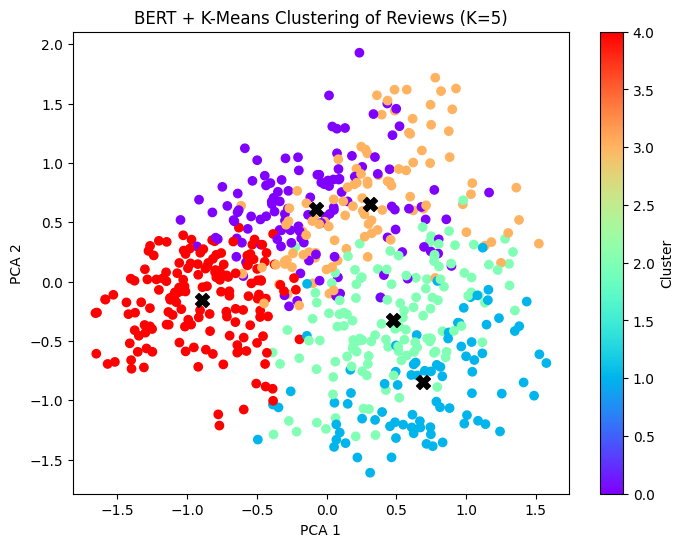

In [74]:
get_pca_score("BERT", bert_rating_combined_vectors)

### falcon PCA

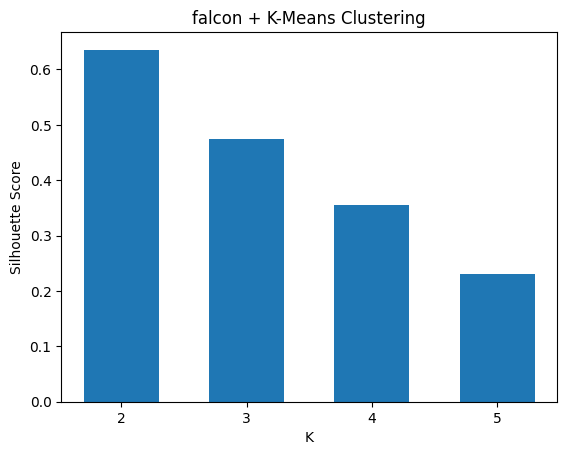

In [95]:
score_barchart("falcon", falcon_rating_combined_vectors)

In [96]:
# save the best k value
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(falcon_rating_combined_vectors)
df['falcon_cluster'] = clusters

df.to_csv('All Reviews_cluster.csv', index=False)

Silhouette Score for k=2: 0.636


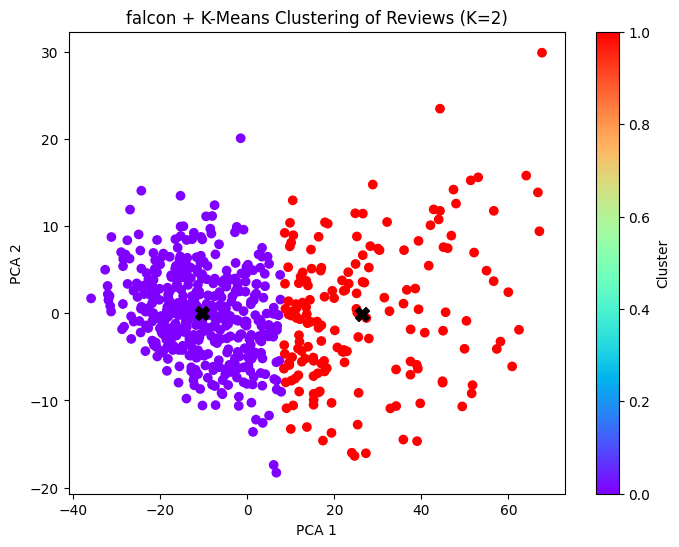

Silhouette Score for k=3: 0.474


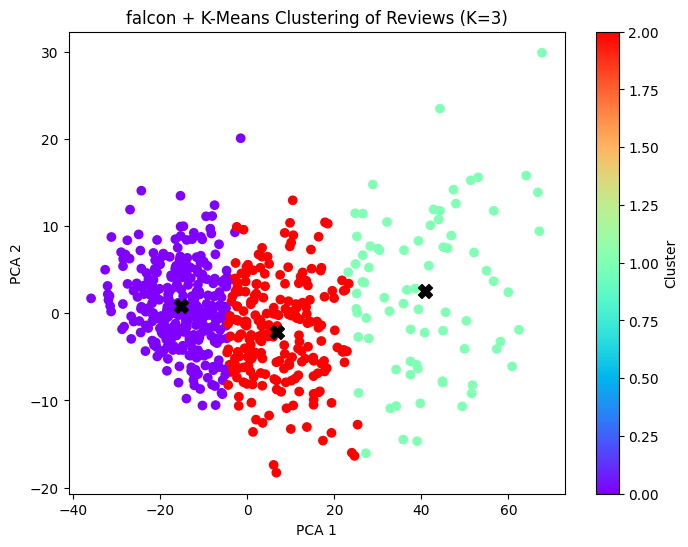

Silhouette Score for k=4: 0.355


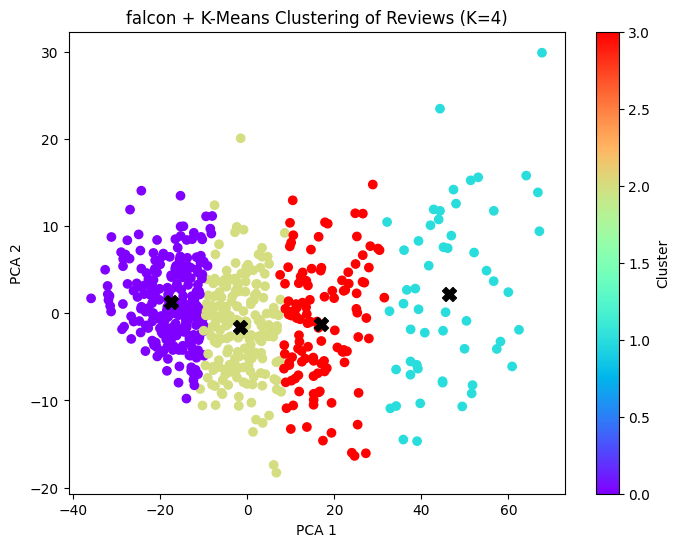

Silhouette Score for k=5: 0.231


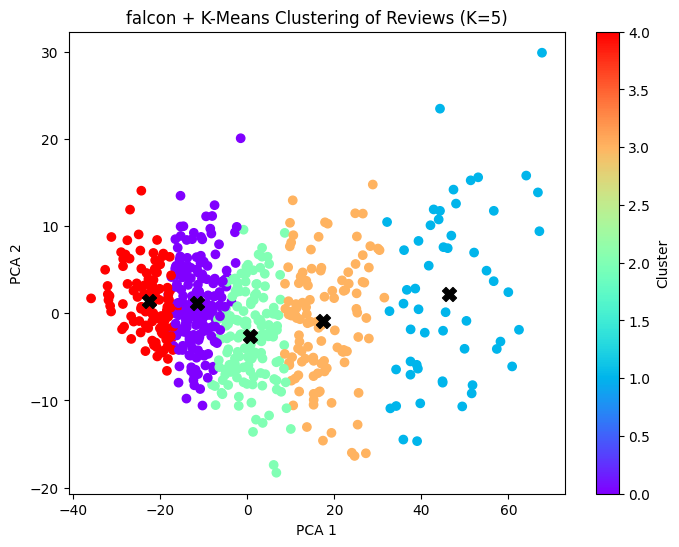

In [75]:
get_pca_score("falcon", falcon_rating_combined_vectors)

### llama PCA

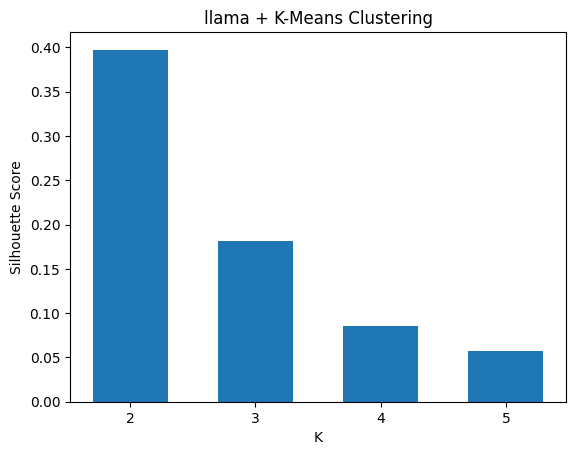

In [27]:
score_barchart("llama", llama_rating_combined_vectors)

In [29]:
# save the best k value
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(llama_rating_combined_vectors)
df['llama_cluster'] = clusters

df.to_csv('All Reviews_cluster_llama.csv', index=False)

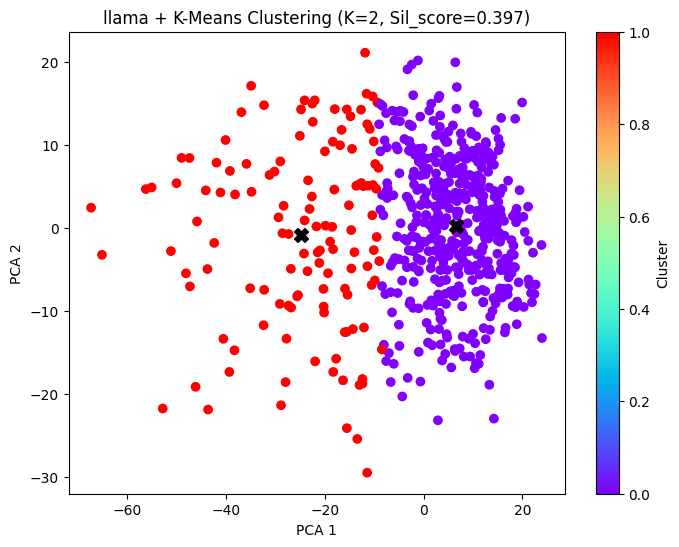

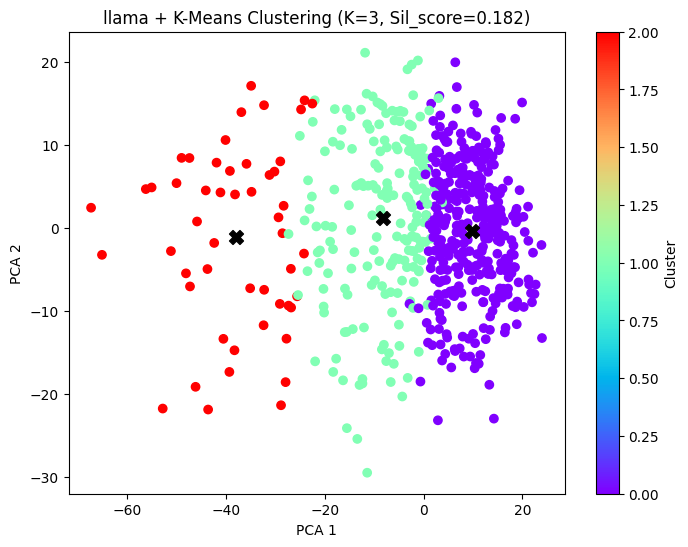

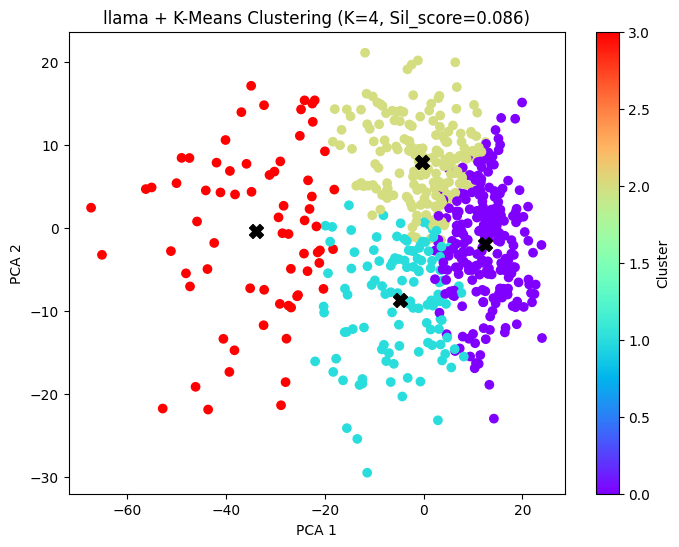

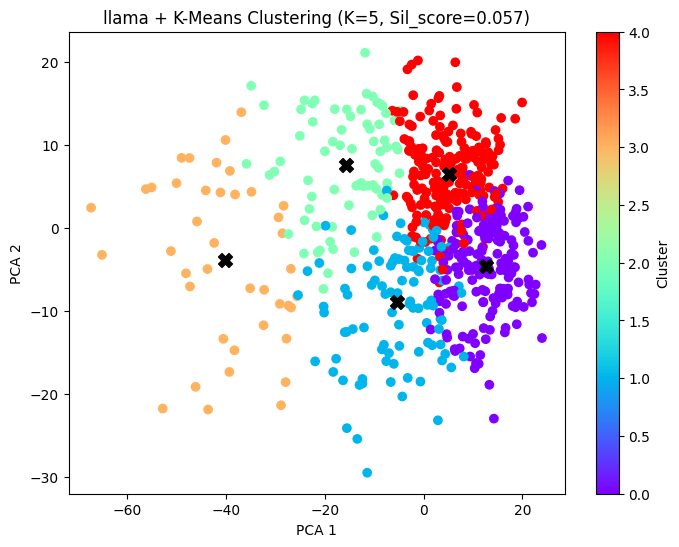

In [30]:
get_pca_score("llama", llama_rating_combined_vectors)

## Analyze cluster ratings

In [ ]:
# df.groupby("cluster")["rating"].mean()